# PyVRP: Hybrid Genetic Search for the VRPTW
This notebook contains an example of how to use the PyVRP library to solve the Vehicle Routing Problem with Time Windows (VRPTW).

### Imports

In [1]:
import os
import sys
import numpy as np
from typing import Callable, Dict, List, Optional
from functools import partial

import pyvrp
from pyvrp import (
    diagnostics,
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    Population,
    Result,
    read
)

from pyvrp._lib.hgspy import (
    Individual,
    LocalSearch,
    PenaltyManager,
    ProblemData,
    XorShift128,
    crossover,
    diversity,
    operators,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

# TODO add as dependency
sys.path.append(os.path.join("..", "..", "..", "CVRPLIB"))
import cvrplib

import matplotlib.pyplot as plt
from pyvrp import plotting

has_pandas = True
try:
    import pandas as pd
    from IPython.display import display
except ImportError:
    has_pandas = False

### Read instance and convert to ProblemData

In [2]:
DATA_ROOT = os.path.abspath(os.path.join("..", "..", "data"))
SOLOMON_DIR = os.path.join(DATA_ROOT, "vrptw", "Solomon")
ORTEC_DIR = os.path.join(DATA_ROOT, "vrptw", "ORTEC")
GH_DIR = os.path.join(DATA_ROOT, "vrptw", "GH")

# For DIMACS objective, we may want to truncate to 1 decimal (scale and truncate to int)
def scale_and_truncate_to_decimals(vals: np.ndarray, decimals: int = 0):
    return (vals * (10 ** decimals)).astype(int)

scale_and_truncate_to_1_decimal = partial(
    scale_and_truncate_to_decimals, decimals=1)

def convert_to_int(vals: np.ndarray):
    return vals.astype(int)

# convert it to a ProblemData object
def create_problem_data(instance: Dict, round_func: Callable = convert_to_int):
    return ProblemData(
        round_func(instance['node_coord']),
        instance['demand'],
        instance['vehicles'],
        instance['capacity'],
        round_func(instance['time_window']),
        round_func(instance['service_time']),
        round_func(instance['distance']),
        np.zeros_like(instance['demand'])
    )

instance_name = "RC208"
instance = create_problem_data(
    cvrplib.read_instance(os.path.join(SOLOMON_DIR, f"{instance_name}.txt"), style='solomon'),
    round_func=scale_and_truncate_to_1_decimal
)
instance_bks = cvrplib.read_solution(os.path.join(SOLOMON_DIR, f"{instance_name}.sol")) 

### Plot instance data

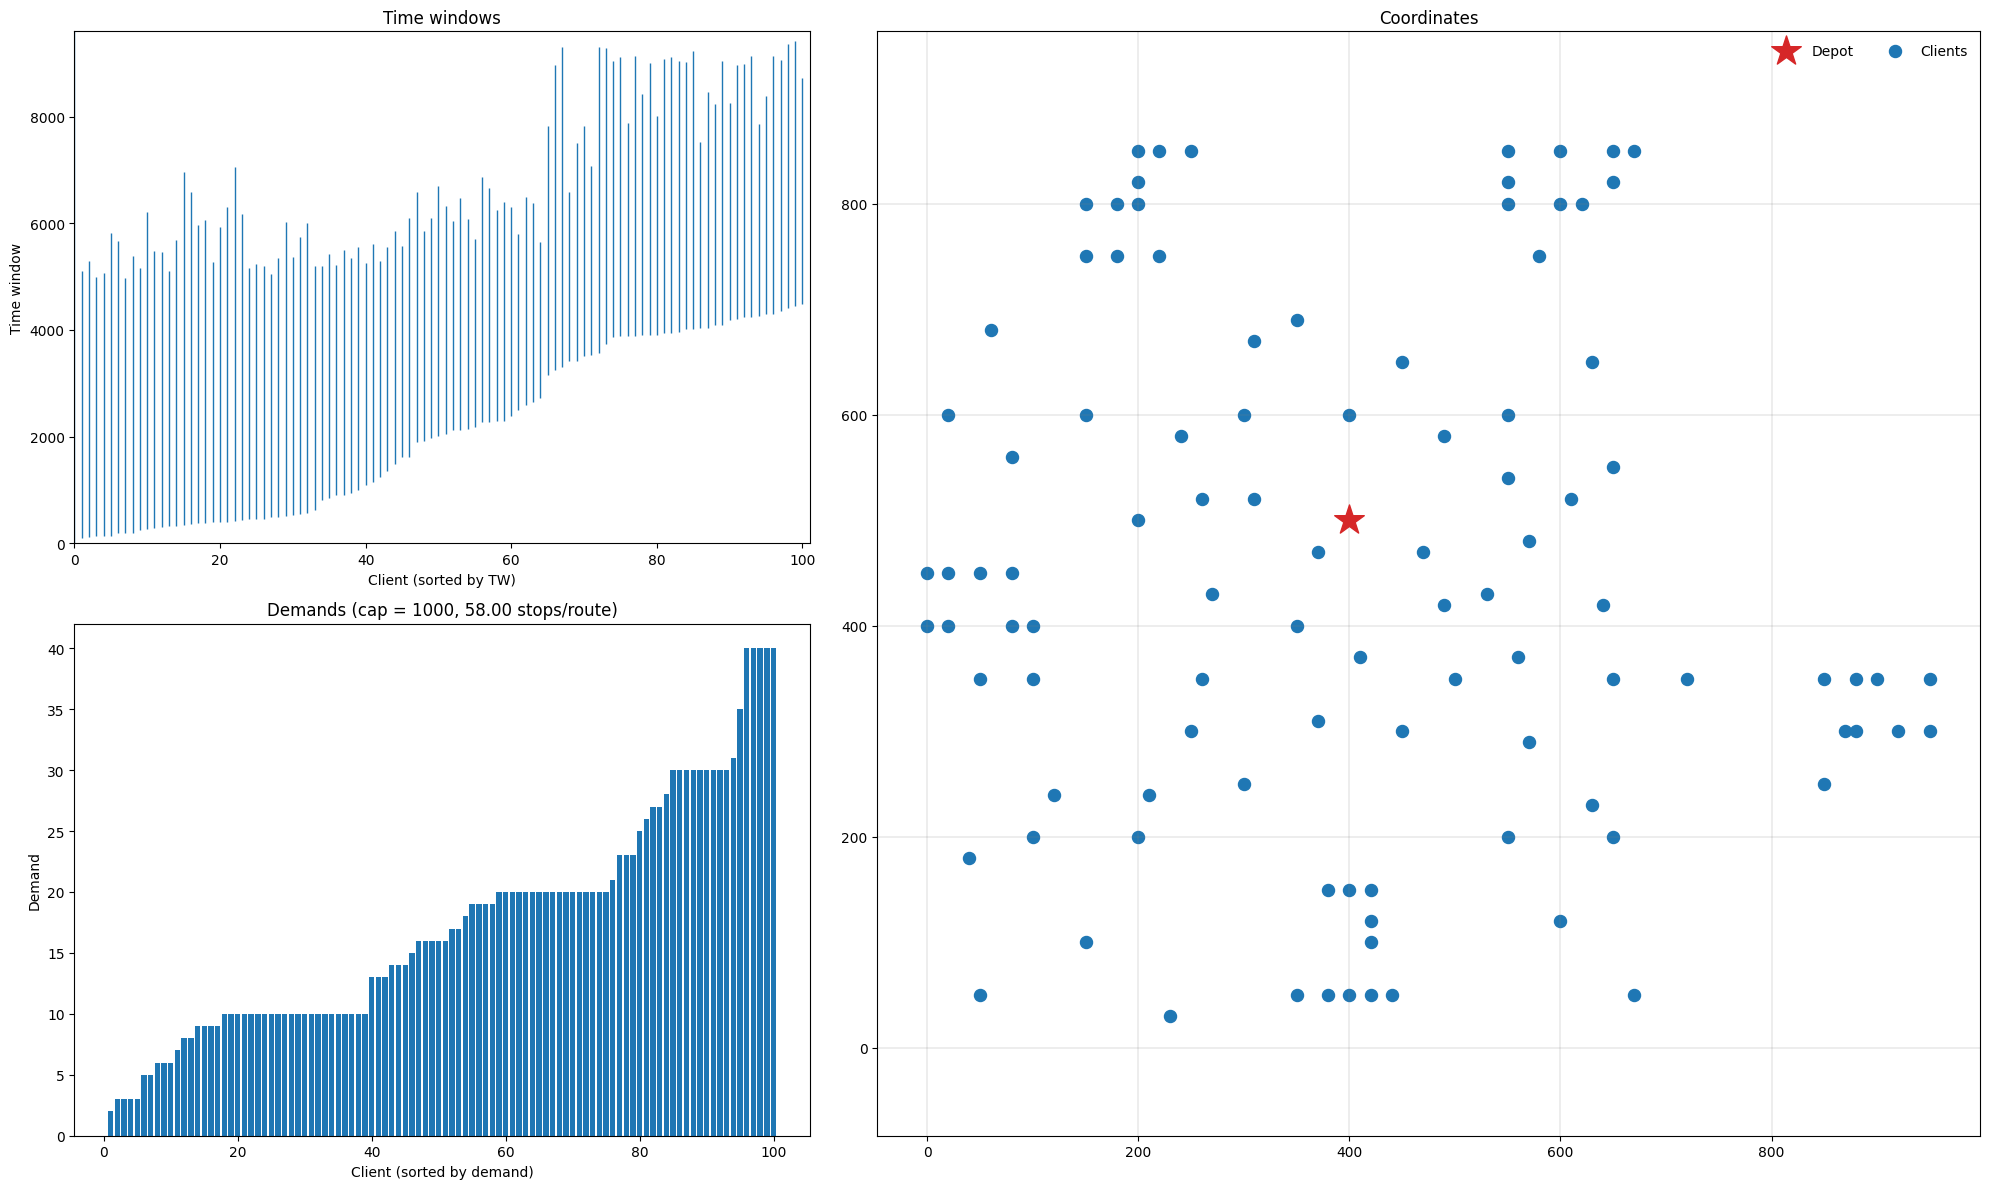

In [3]:
plotting.plot_instance(instance)

### Configure Hybrid Genetic Search

In [4]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)

    div_op = diversity.broken_pairs_distance
    pop = Population(data, pen_manager, rng, div_op)
    ls = LocalSearch(data, pen_manager, rng)

    node_ops = [
        operators.Exchange10(data, pen_manager),
        operators.Exchange20(data, pen_manager),
        operators.MoveTwoClientsReversed(data, pen_manager),
        operators.Exchange22(data, pen_manager),
        operators.Exchange21(data, pen_manager),
        operators.Exchange11(data, pen_manager),
        operators.TwoOpt(data, pen_manager),
    ]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops: list = [
        operators.RelocateStar(data, pen_manager),
        operators.SwapStar(data, pen_manager),
    ]

    for op in route_ops:
        ls.add_route_operator(op)

    crossover_op = crossover.selective_route_exchange
    genetic_params = GeneticAlgorithmParams()
    genetic_params.collect_statistics = True
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, crossover_op, genetic_params)

    if max_runtime is not None:
        stop: StoppingCriterion = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

### Set arguments and run algorithm

In [5]:
args = {
    'seed': 42,
    'max_runtime': 10
}
result = solve(instance, **args)
solution = result.best
# Note the scaling of the solution cost
print(f"Total cost of solution: {solution.cost() / 10}, BKS = {instance_bks['cost']}")

Total cost of solution: 778.7, BKS = 776.1


### Plot results

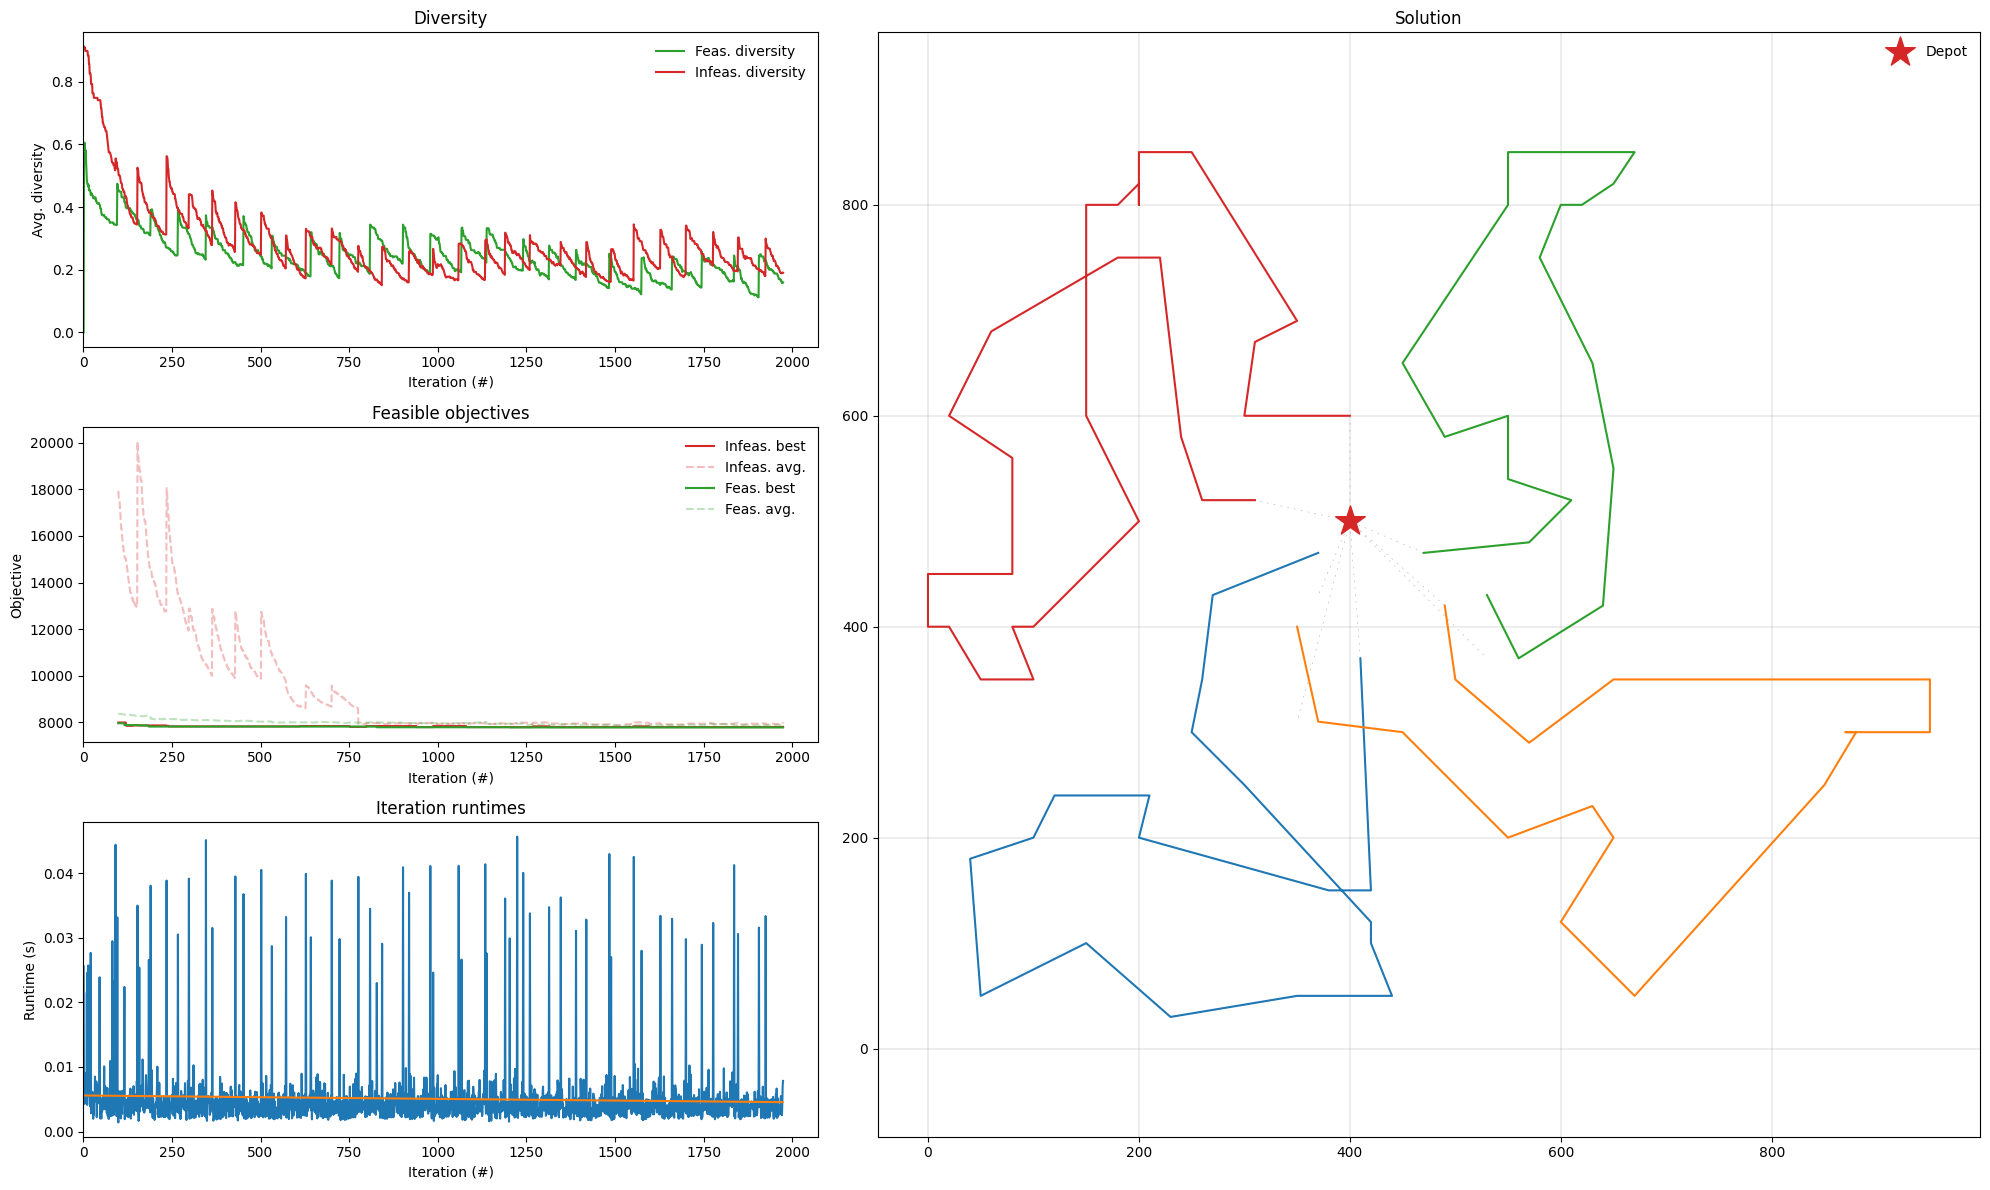

In [6]:
plotting.plot_result(result, instance)

### Inspect route statistics

In [7]:
route_stats = diagnostics.get_all_route_statistics(solution, instance)
# Verify that cost is equal to total distance
assert sum([s.distance for s in route_stats]) == solution.cost()

if has_pandas:
    route_stats_df = pd.DataFrame(route_stats)
    display(route_stats_df.head())
else:
    print(route_stats[0])

,distance,start_time,end_time,duration,timewarp,wait_time,service_time,num_stops,total_demand,fillrate,is_feasible,is_empty
0,1970,0,6912,6912,0,2542,2400,24,418,0.418,True,False
1,1886,0,6262,6262,0,2176,2200,22,363,0.363,True,False
2,1643,0,6384,6384,0,2541,2200,22,351,0.351,True,False
3,2288,0,7423,7423,0,1935,3200,32,592,0.592,True,False
4,0,0,0,0,0,0,0,0,0,0.000,True,True


### Plot route schedules

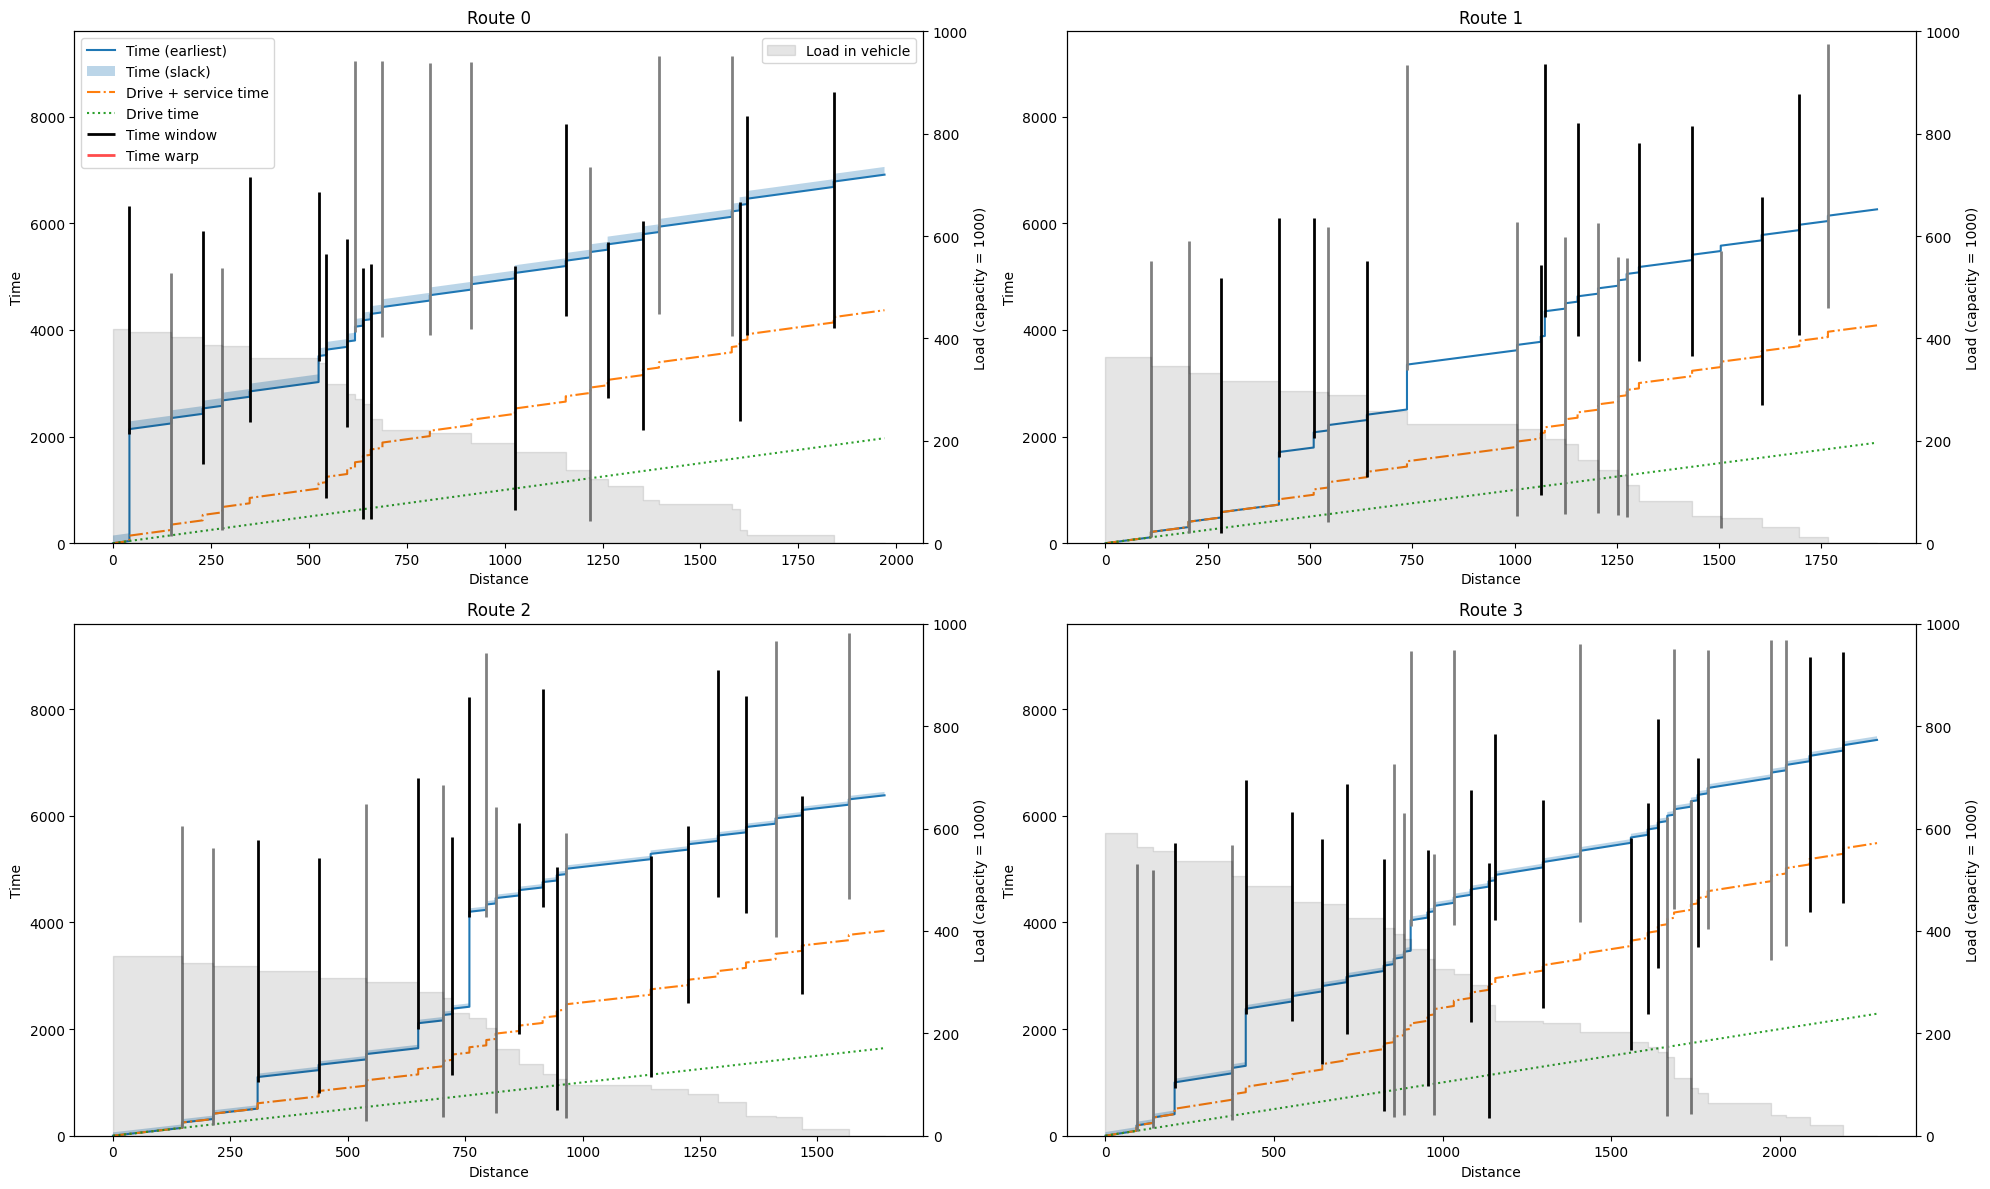

In [8]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
routes = solution.get_routes()
for i, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
    plotting.plot_route_schedule(instance, route, title=f'Route {i}', ax=ax, legend=i==0)
fig.tight_layout()

## Running larger instances

### Gehring & Homberger instance

Total cost of solution: 28358.1, BKS = 25797.5


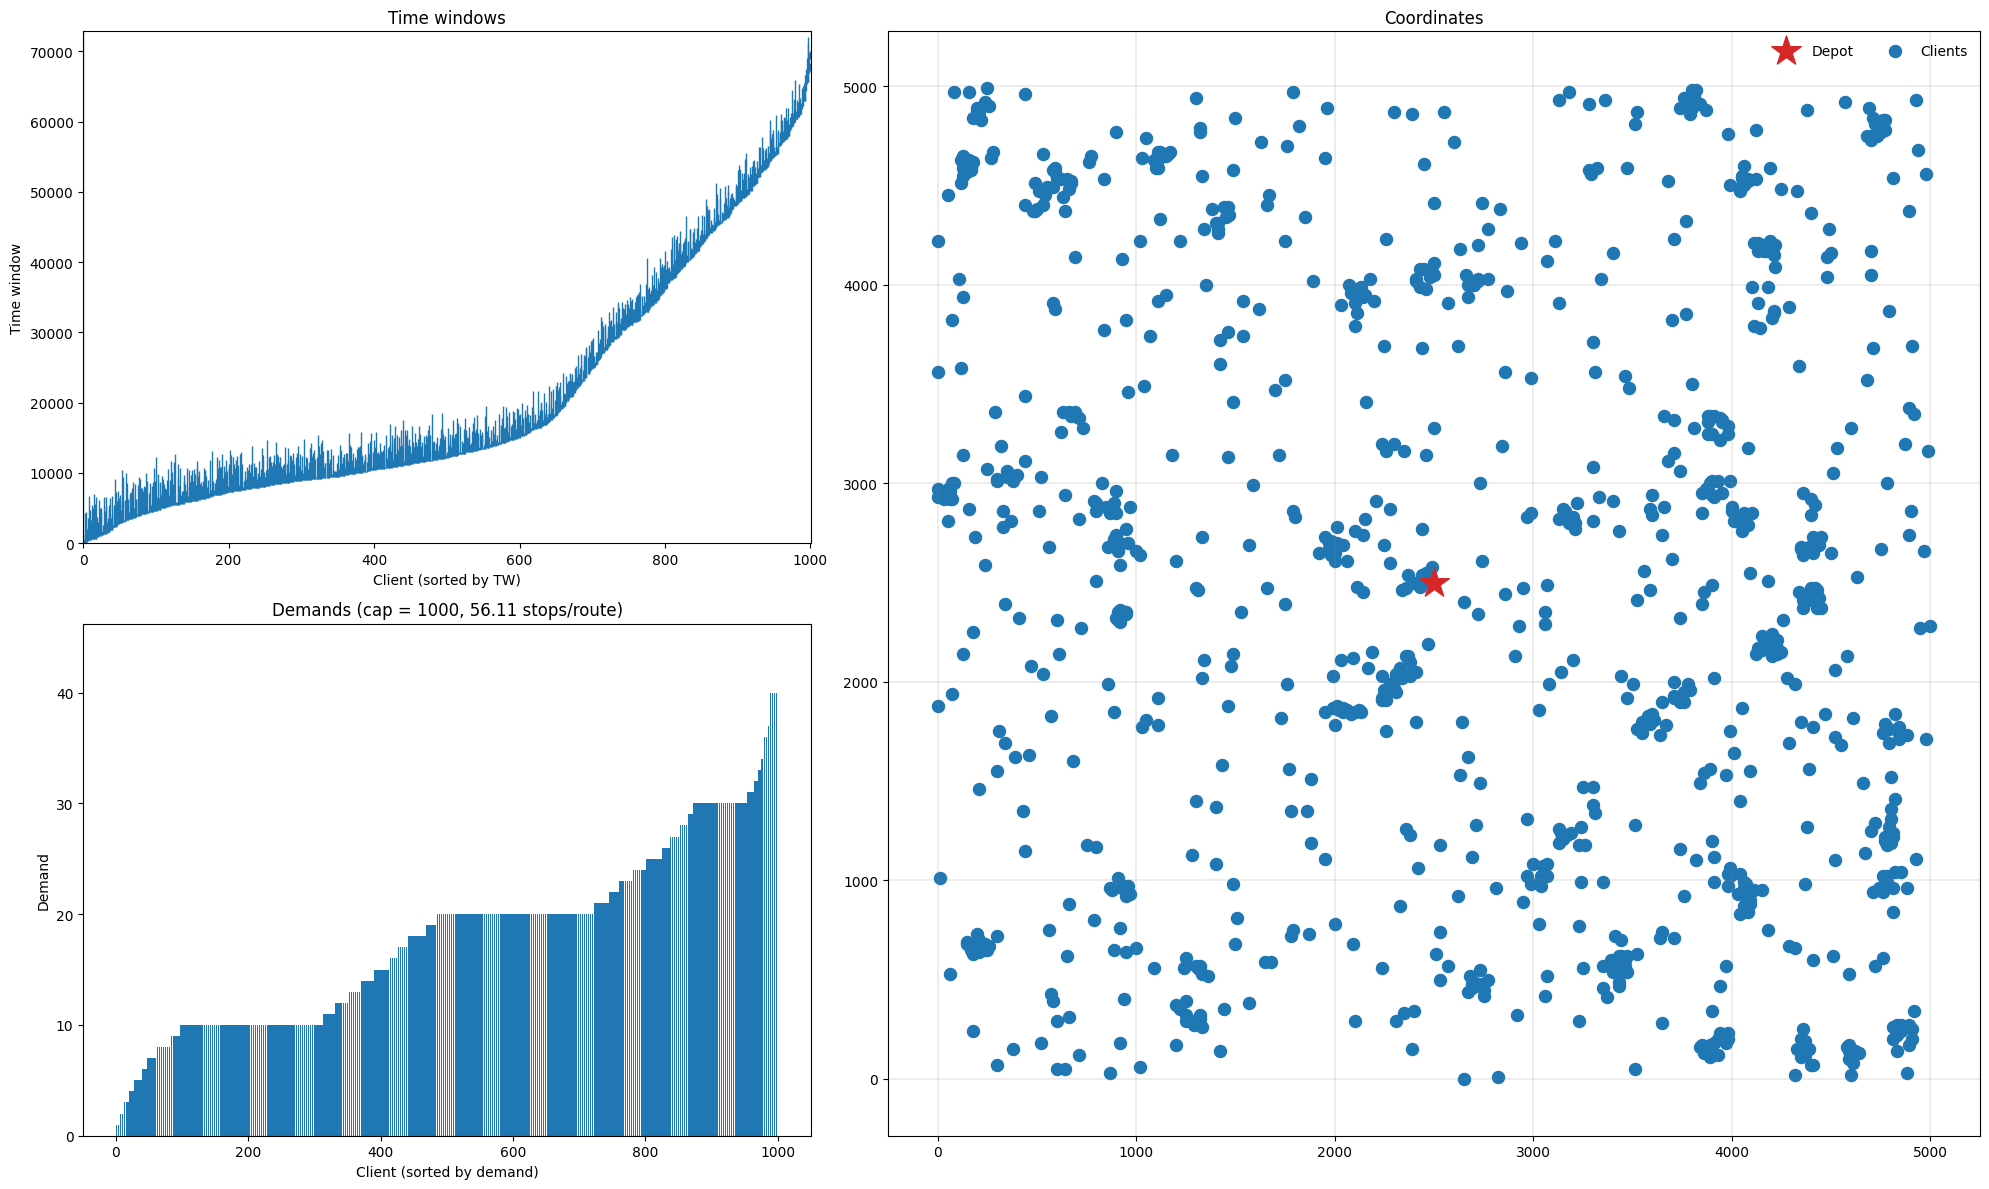

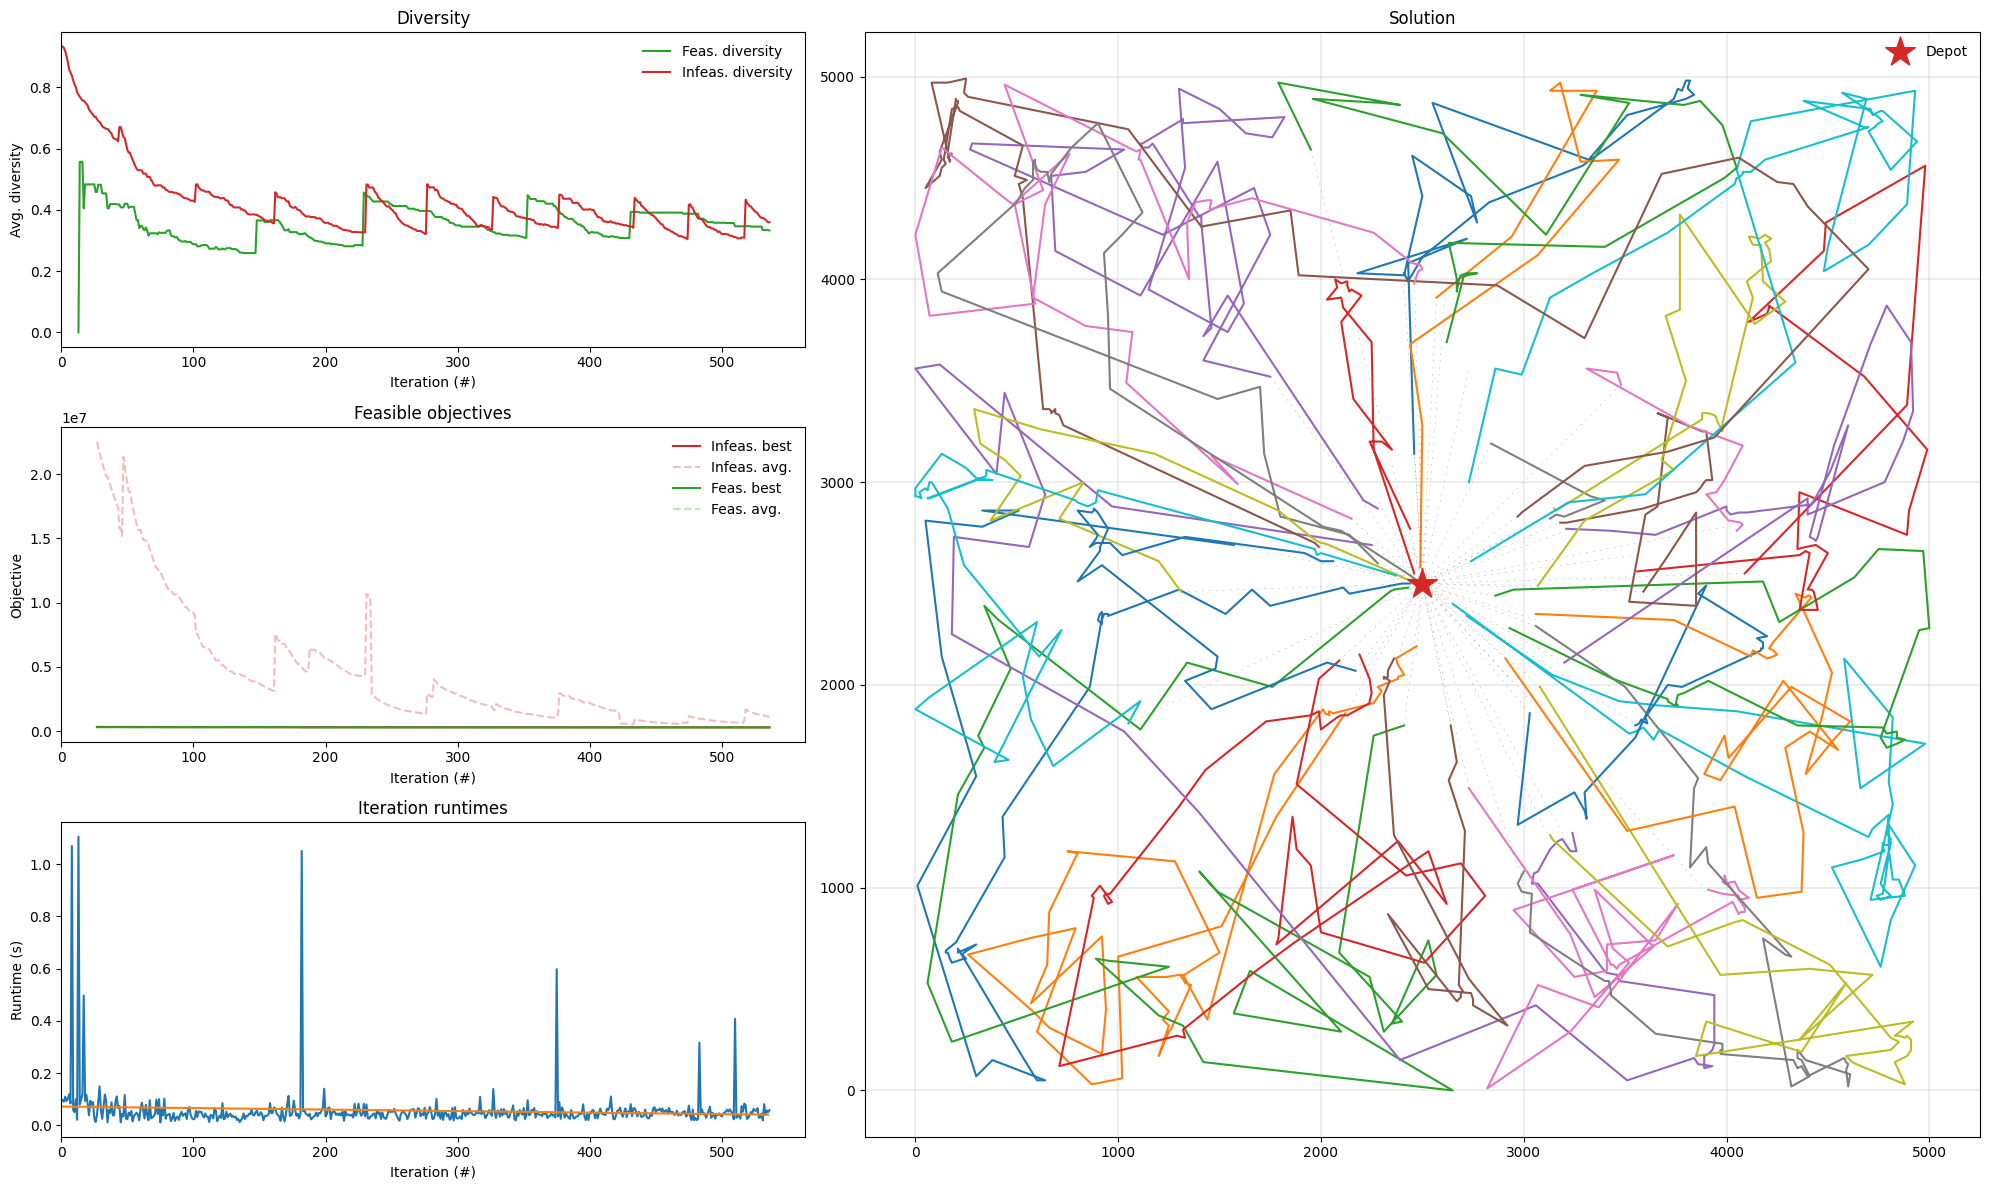

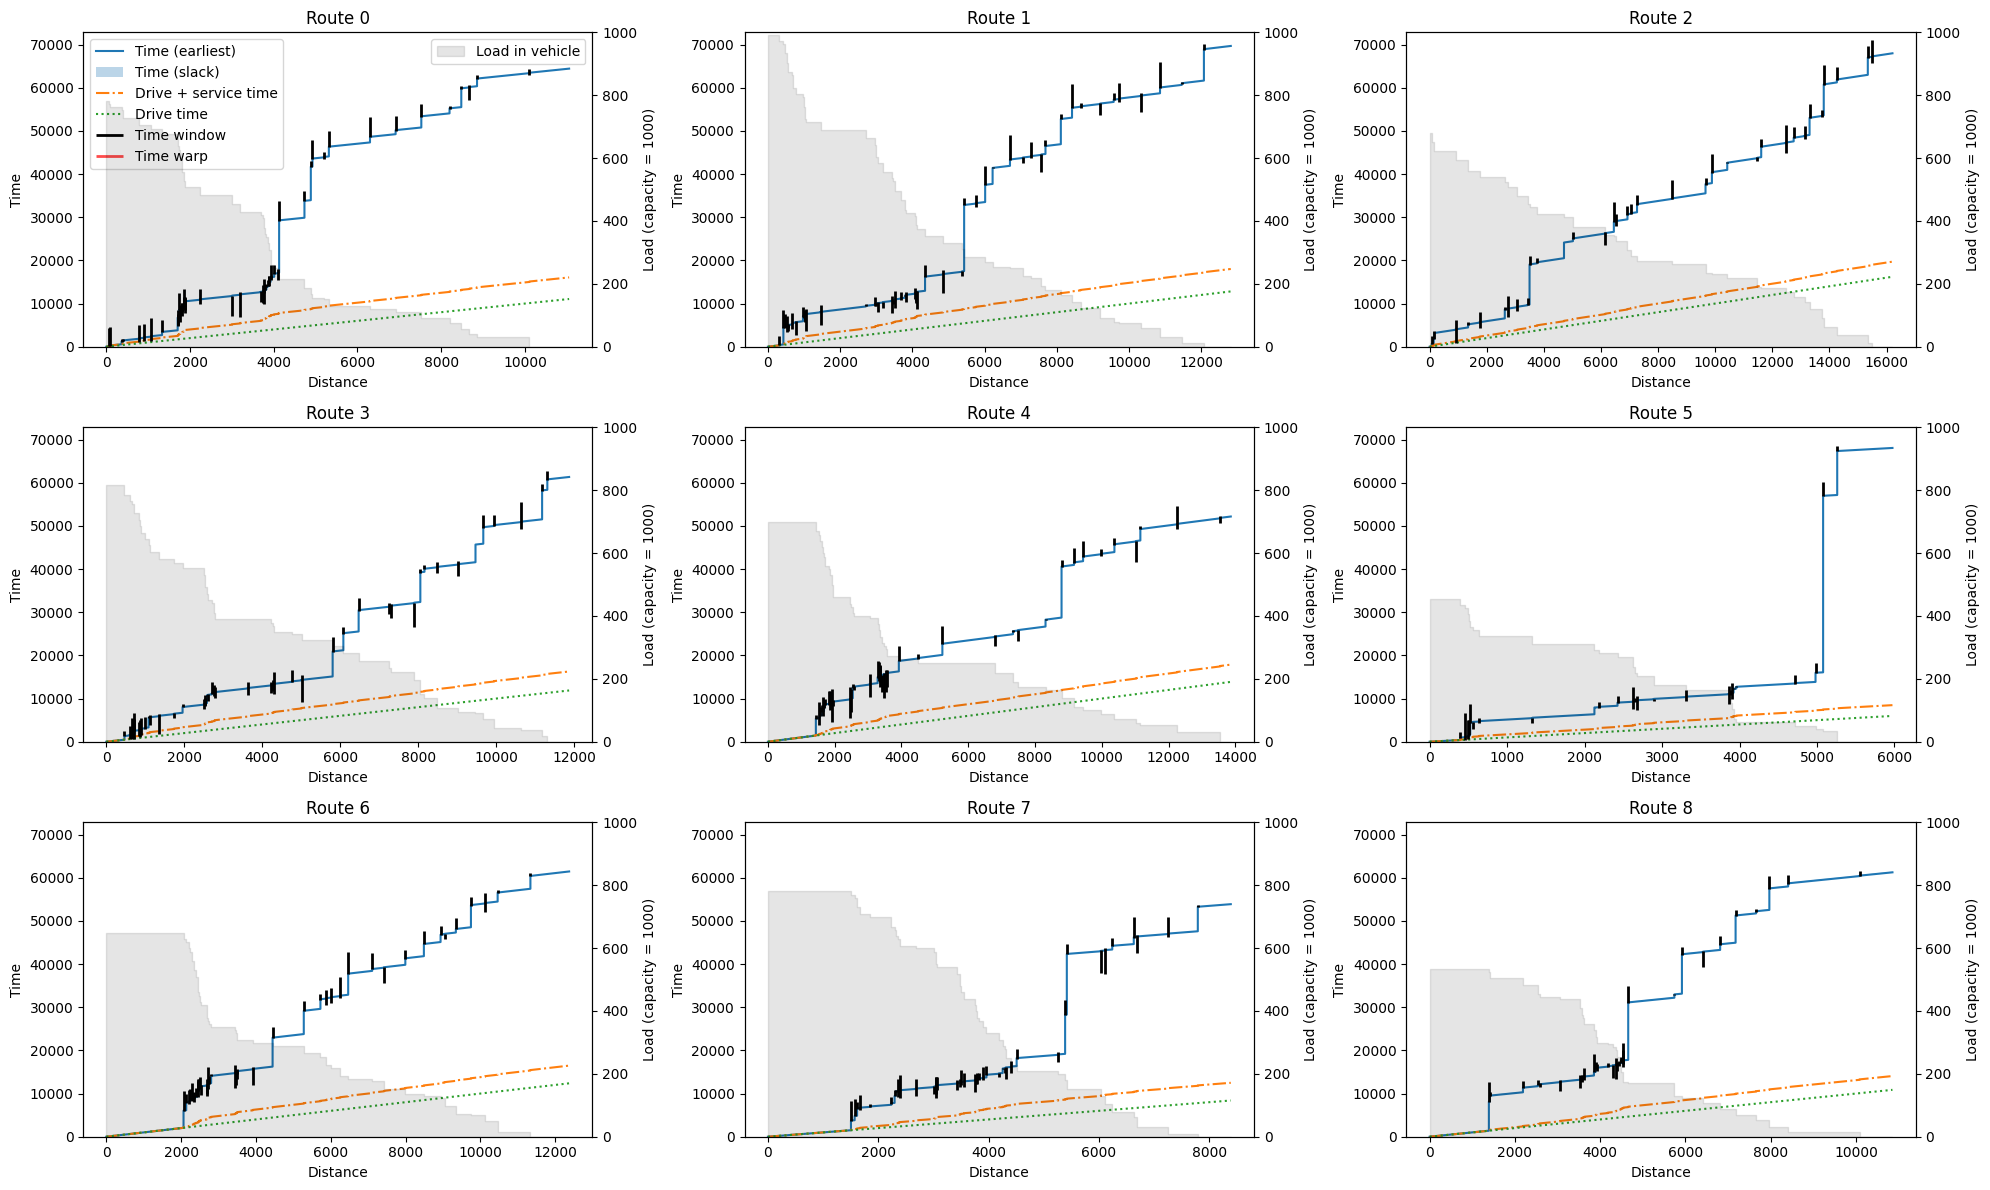

In [9]:
# Read, convert and plot instance
instance_name_gh = 'RC2_10_5'
instance_gh = create_problem_data(
    cvrplib.read_instance(os.path.join(GH_DIR, f"{instance_name_gh}.txt"), style='solomon'),
    round_func=scale_and_truncate_to_1_decimal)
instance_gh_bks = cvrplib.read_solution(os.path.join(GH_DIR, f"{instance_name_gh}.sol")) 
plotting.plot_instance(instance_gh)

# Run HGS algorithm and plot result
args = {
    'seed': 42,
    'max_runtime': 30
}
result_gh = solve(instance_gh, **args)
print(f"Total cost of solution: {result_gh.best.cost() / 10}, BKS = {instance_gh_bks['cost']}")
plotting.plot_result(result_gh, instance_gh)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(20, 12))
for i, (ax, route) in enumerate(zip(axarr.reshape(-1), result_gh.best.get_routes())):
    plotting.plot_route_schedule(instance_gh, route, title=f'Route {i}', ax=ax, legend=i==0)
fig.tight_layout()

### ORTEC instance (from EURO Meets NeurIPS 2022 Competition)

Total cost of solution: 265627


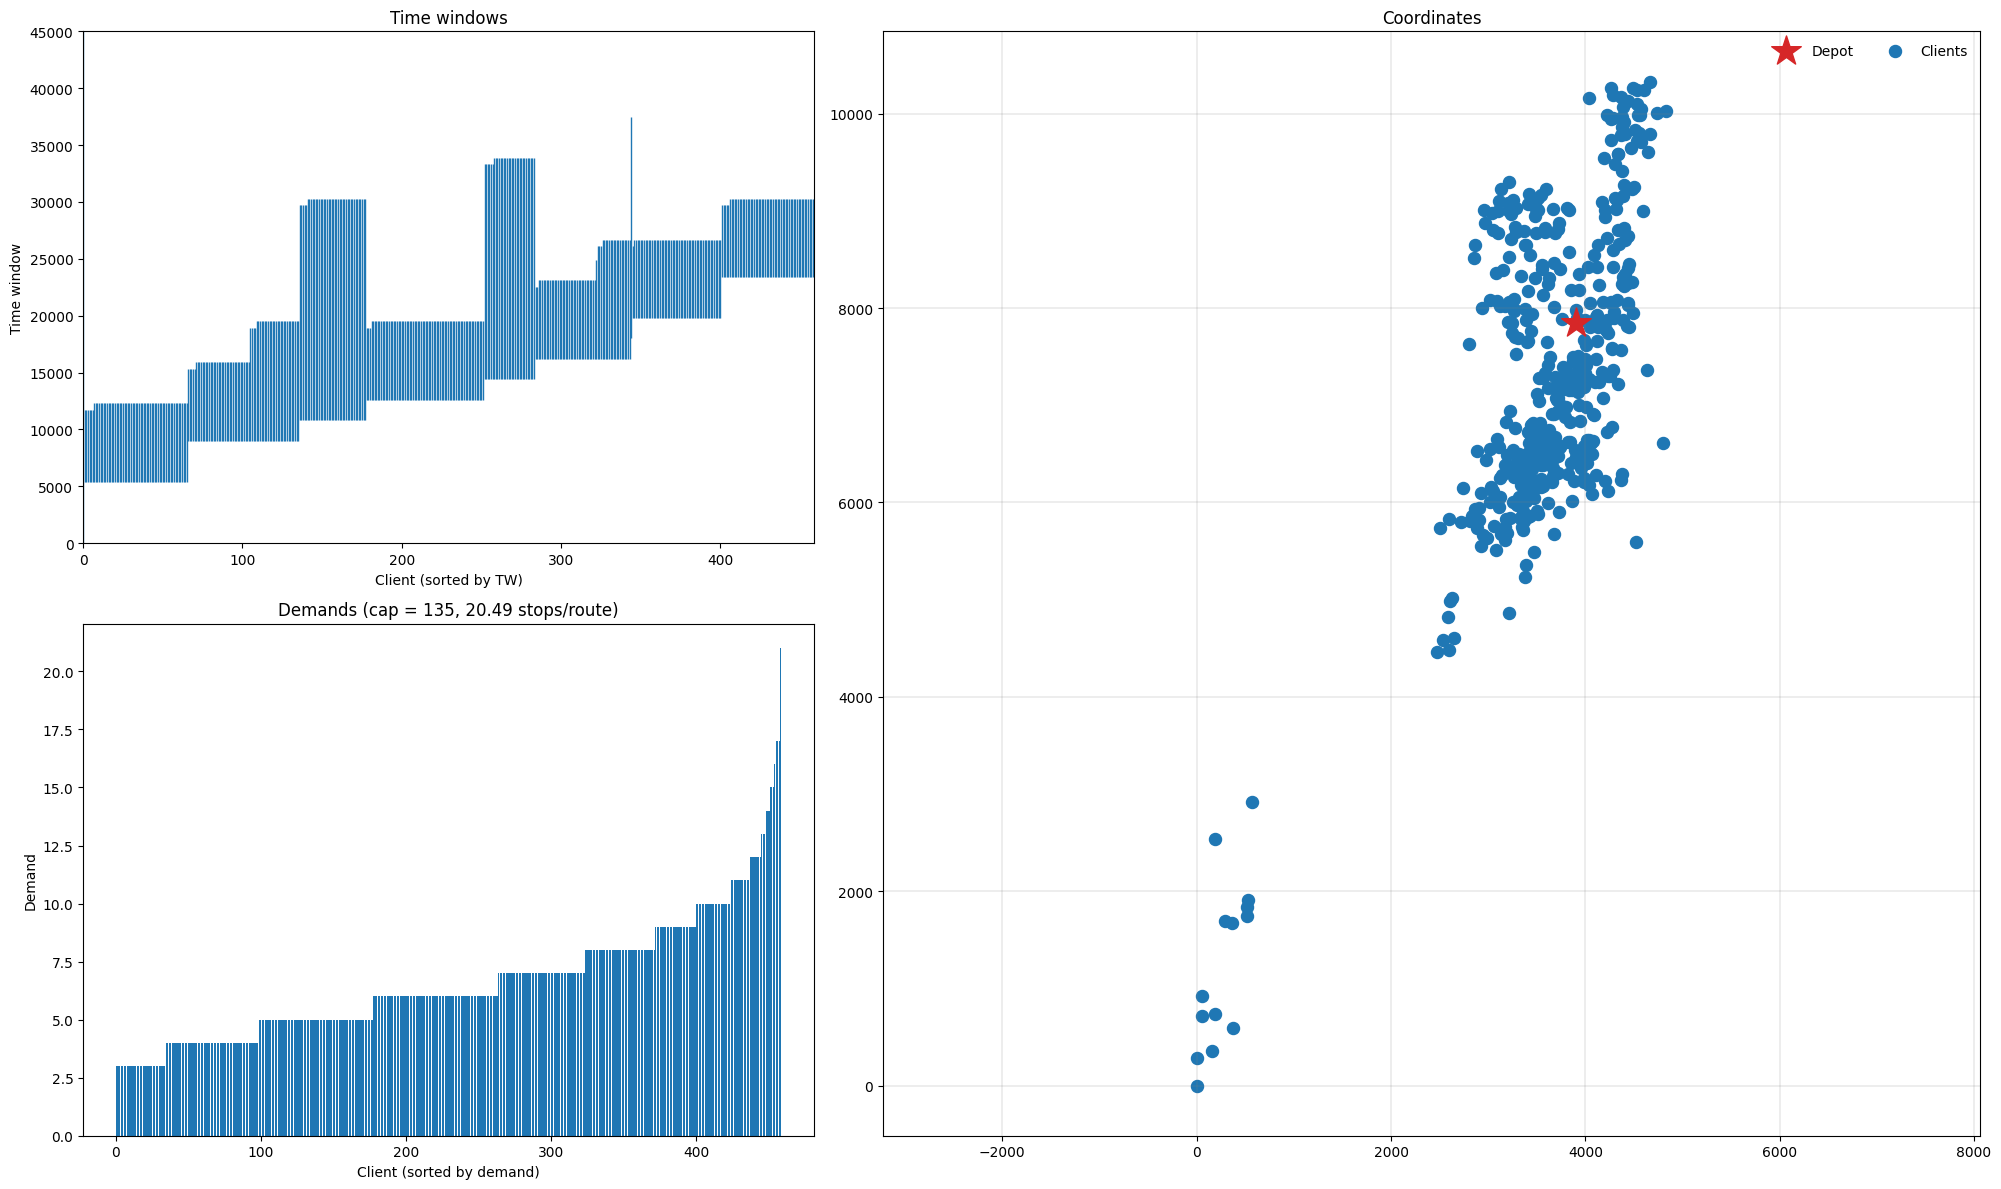

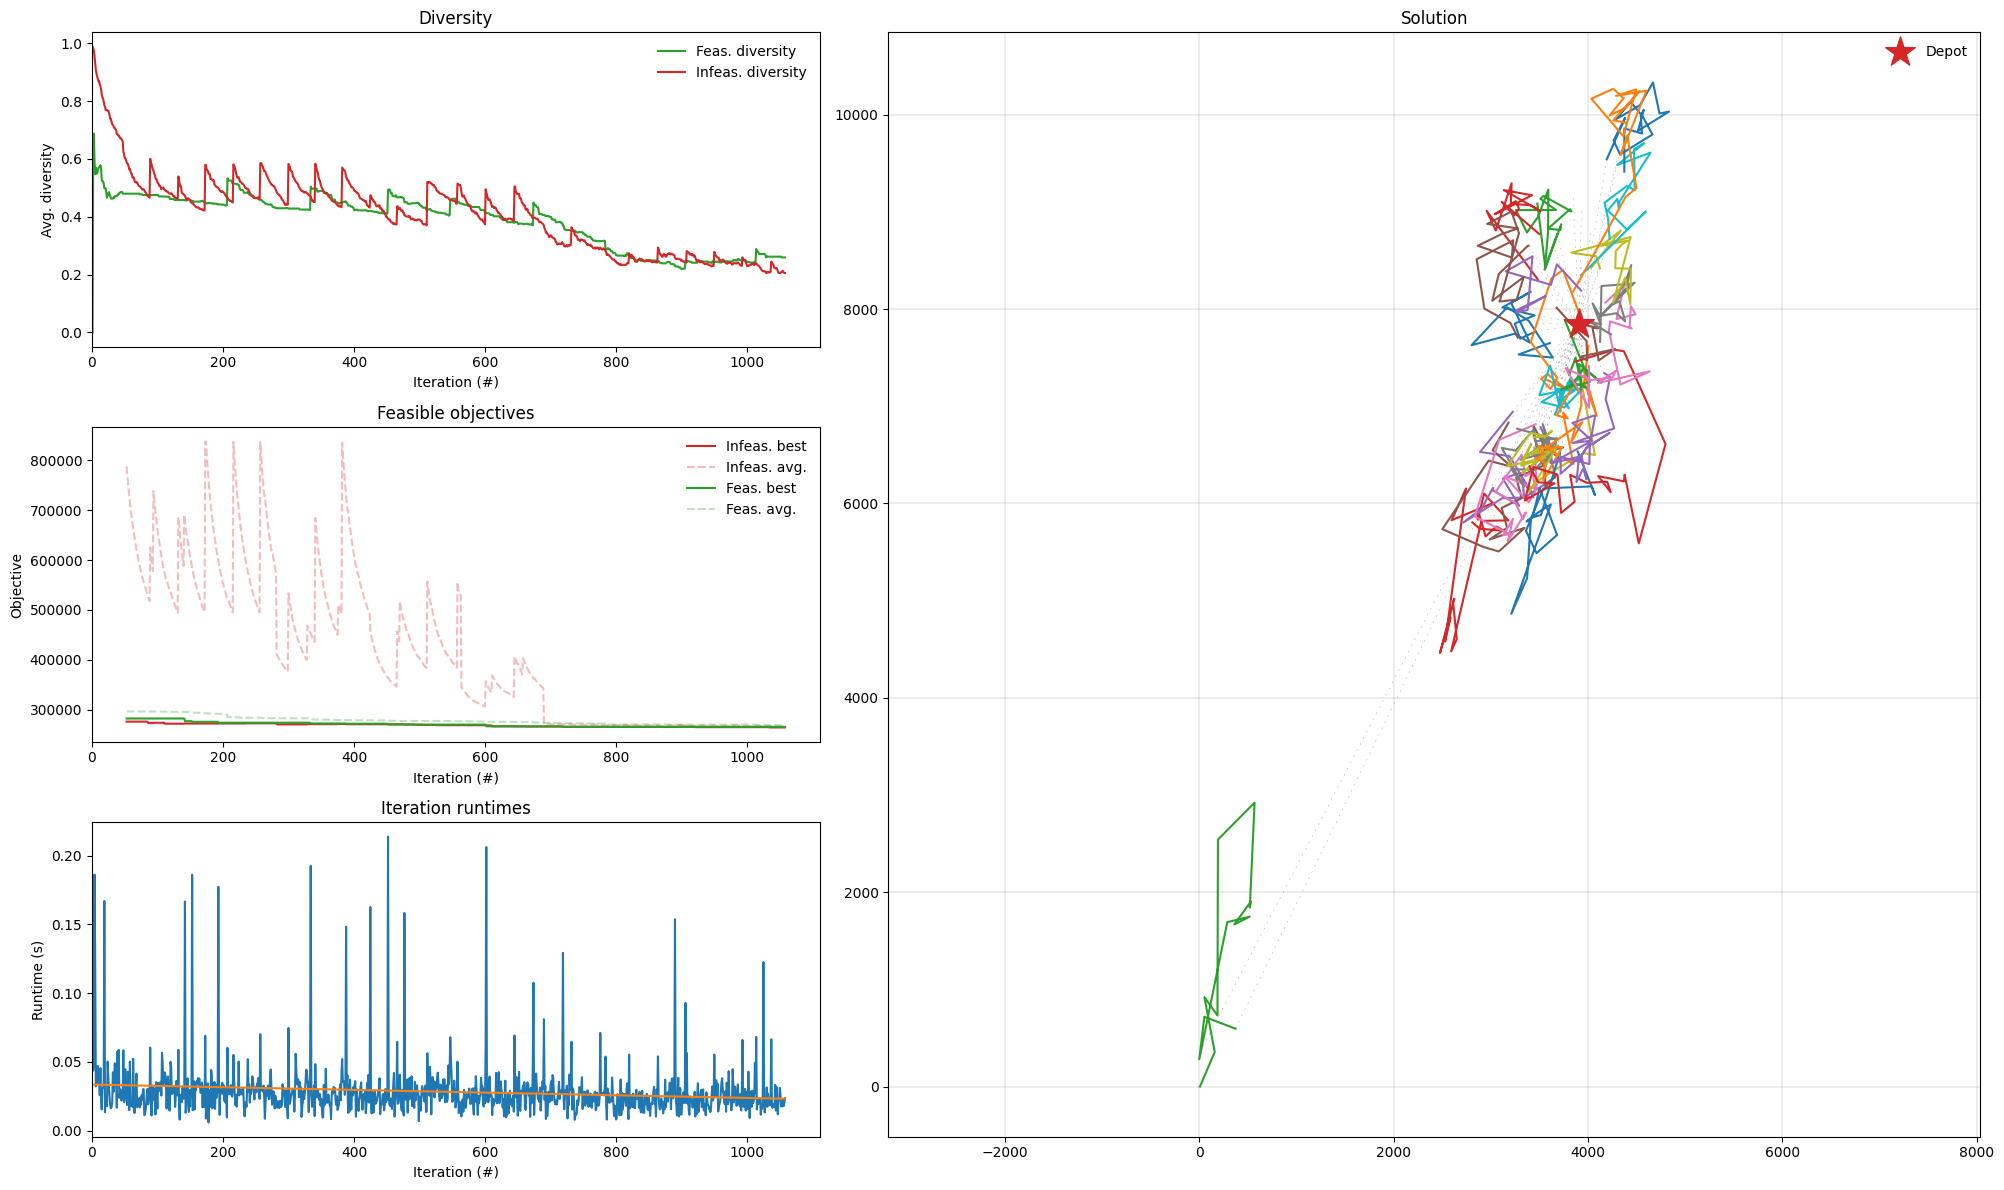

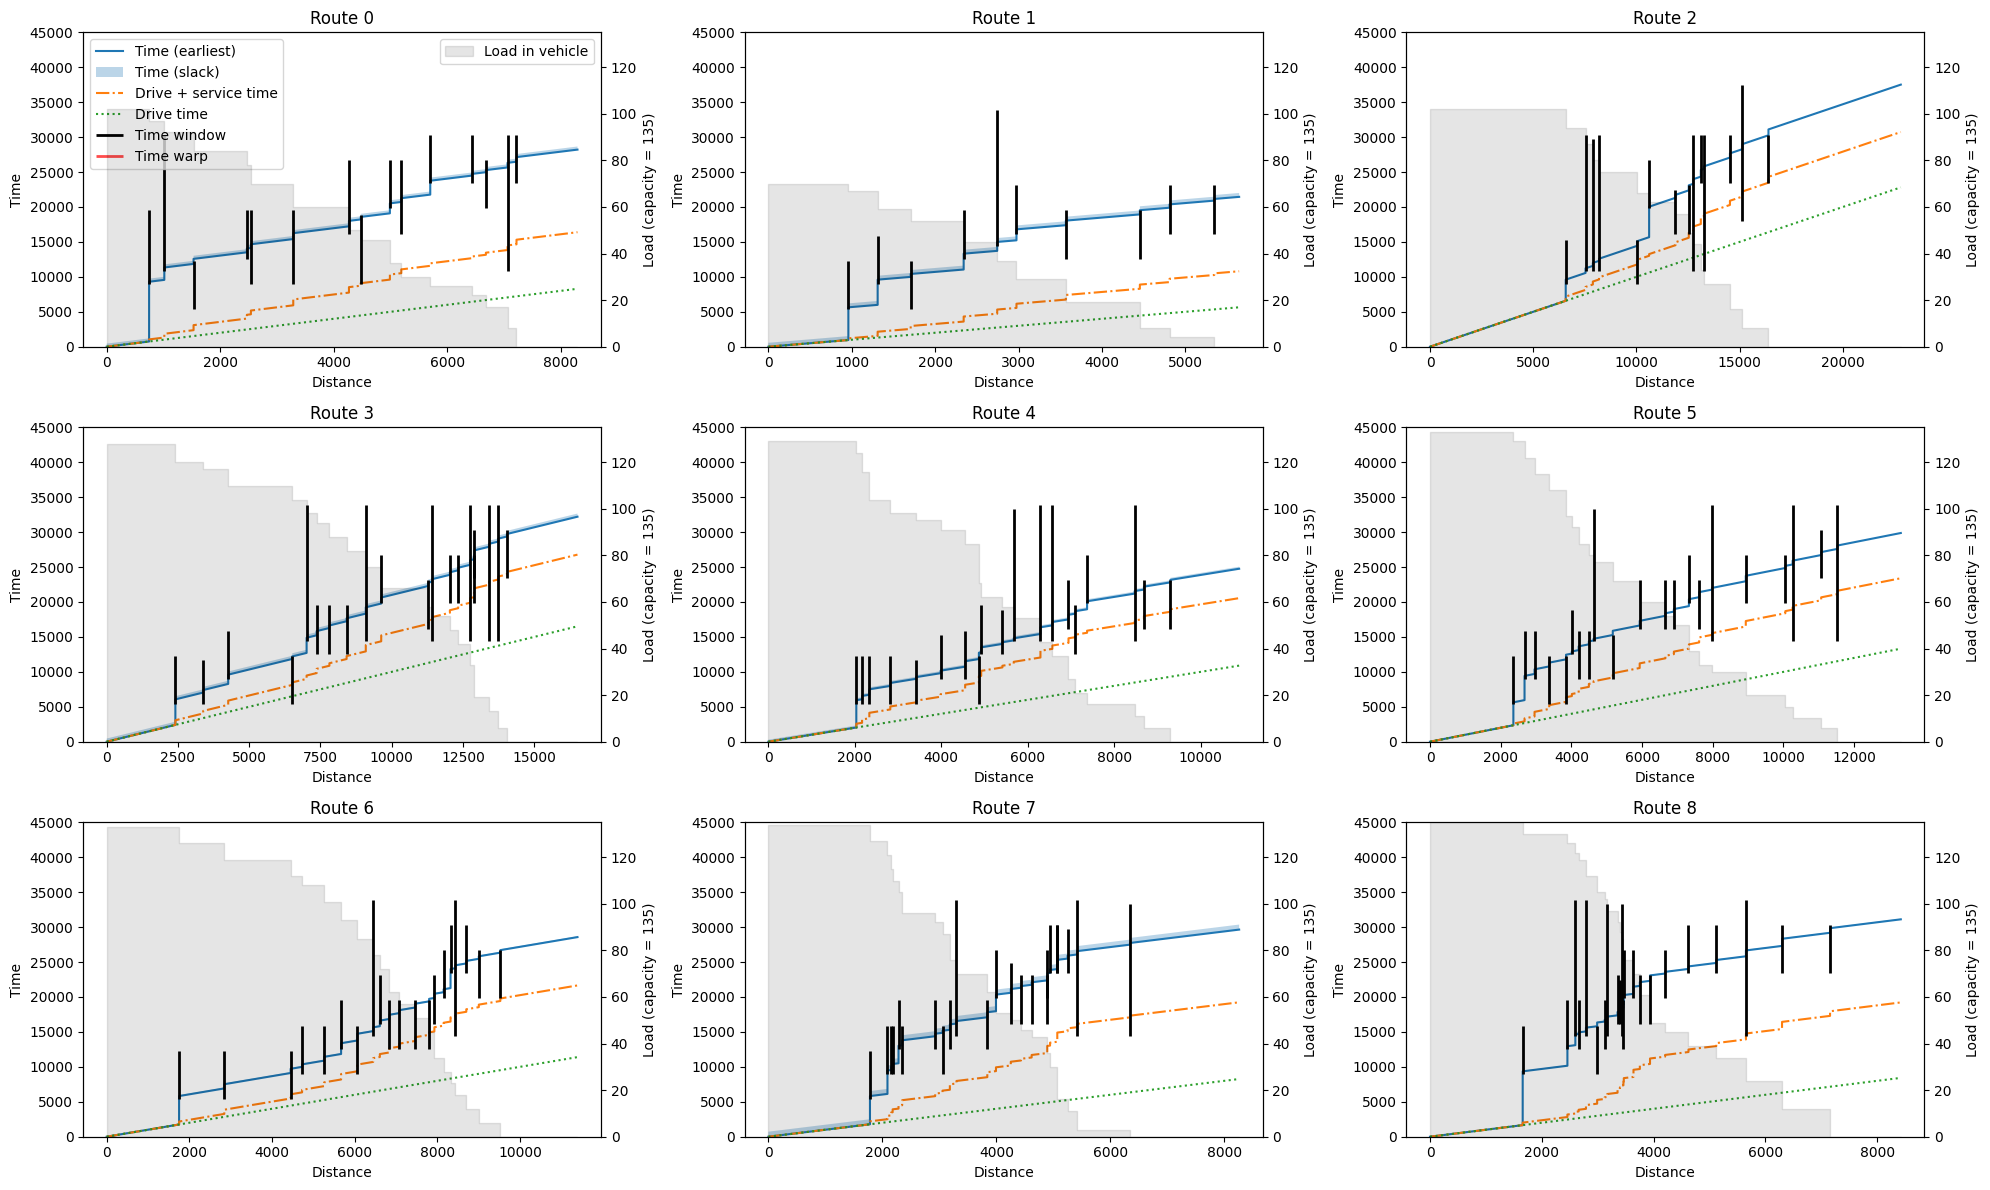

In [10]:
# Read, convert and plot instance
# # instance_name_ortec = "ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12"
instance_name_ortec = 'ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35'
# Note: no need to round as these instances have explicit integer distance matrices
instance_ortec = create_problem_data(
    cvrplib.read_instance(os.path.join(ORTEC_DIR, f"{instance_name_ortec}.txt"), style='vrplib'))
plotting.plot_instance(instance_ortec)

# Run HGS algorithm and plot result
args = {
    'seed': 42,
    'max_runtime': 30
}
result_ortec = solve(instance_ortec, **args)
print(f"Total cost of solution: {result_ortec.best.cost()}")
plotting.plot_result(result_ortec, instance_ortec)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(20, 12))
for i, (ax, route) in enumerate(zip(axarr.reshape(-1), result_ortec.best.get_routes())):
    plotting.plot_route_schedule(instance_ortec, route, title=f'Route {i}', ax=ax, legend=i==0)
fig.tight_layout()